In [1]:
import plotly
import plotly.express as px
import numpy as np

from class_definitions import *
import pandas as pd
from vivino_db import database
db = database.db
db.db_engine.table_names()

Engine(sqlite://///Users/schlinkertc/code/wine_project/wine/vivino_db/vivino_wines.db)


['regions', 'styles', 'vintages', 'wineries', 'wines']

In [2]:
tables = {}
for table in db.db_engine.table_names():
    tables[table]=pd.read_sql_table(table,db.db_engine)

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.shape

(128, 30)

### Countries, Regions

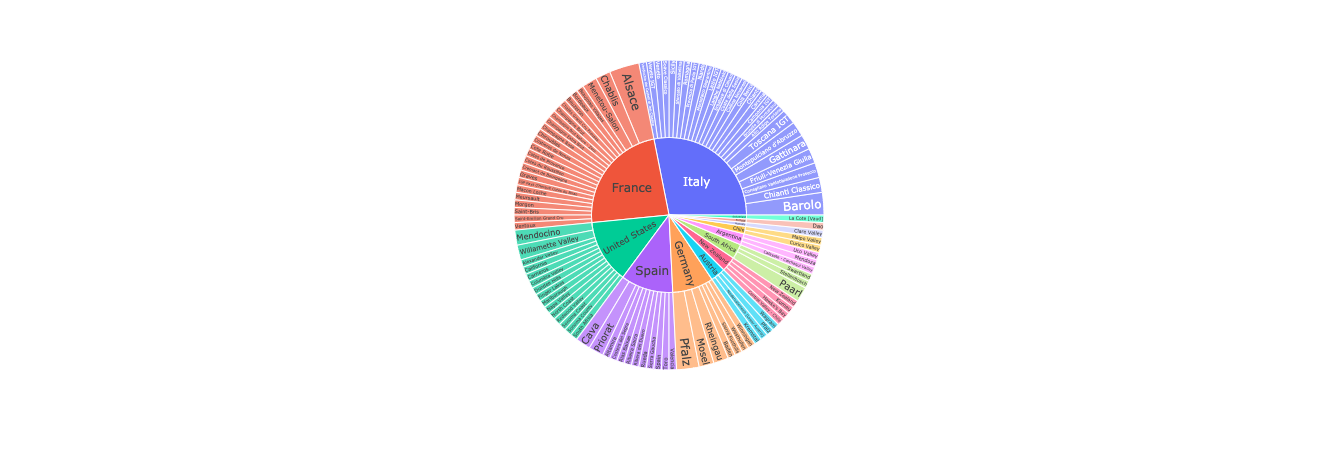

In [10]:
fig = px.sunburst(df,path=['country_name','Region/Appellation'])
fig.write_html('images/countries_regions.html')
fig.show()

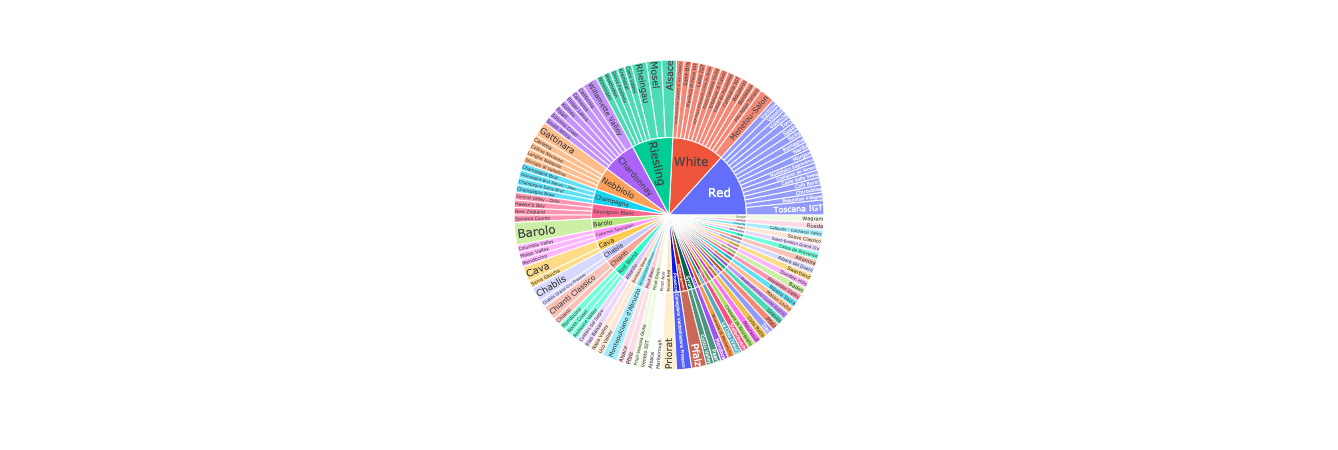

In [35]:
fig = px.sunburst(df,path=['varietal_name','Region/Appellation'])
fig.write_html('images/varietalName_region.html')
fig.show()

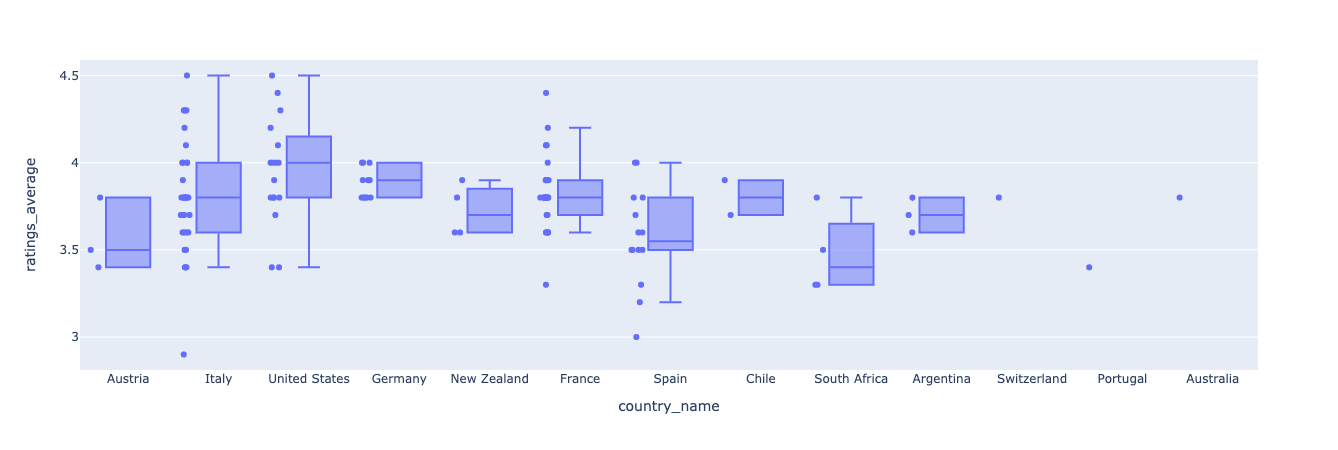

In [34]:
fig = px.box(df[df['ratings_average']!=0],x='country_name',y='ratings_average',points='all',hover_name='name')
fig.update_traces(quartilemethod="exclusive")
fig.write_html('images/country_ratingsAvg.html')
fig.show()

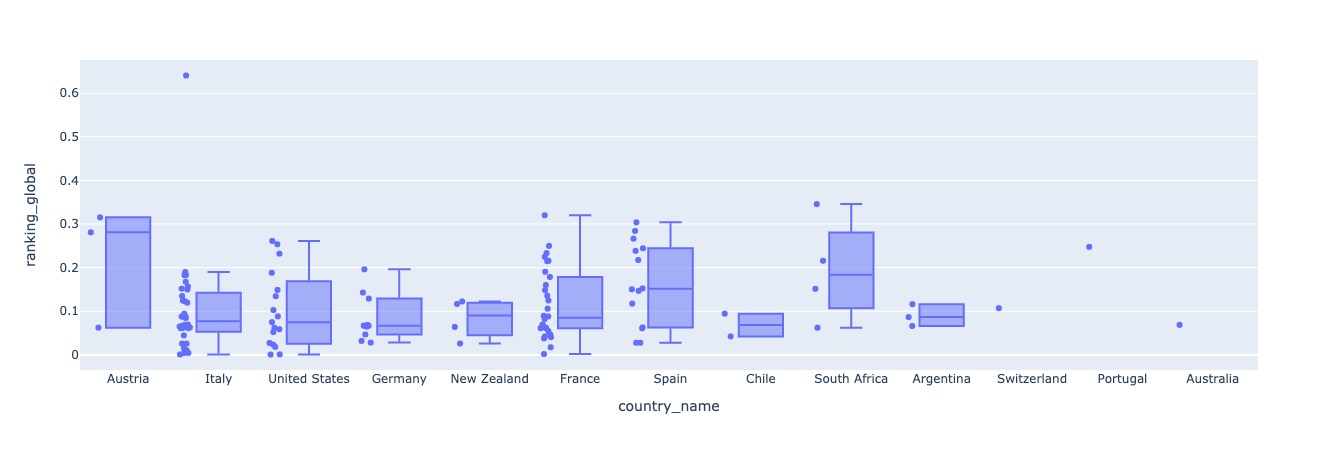

In [33]:
fig = px.box(df[df['ratings_average']!=0],x='country_name',y='ranking_global',points='all',hover_name='name')
fig.update_traces(quartilemethod="exclusive")
fig.write_html('images/country_rankingGlobal.html')
fig.show()

### Type,Wine Style,Grape/Blend

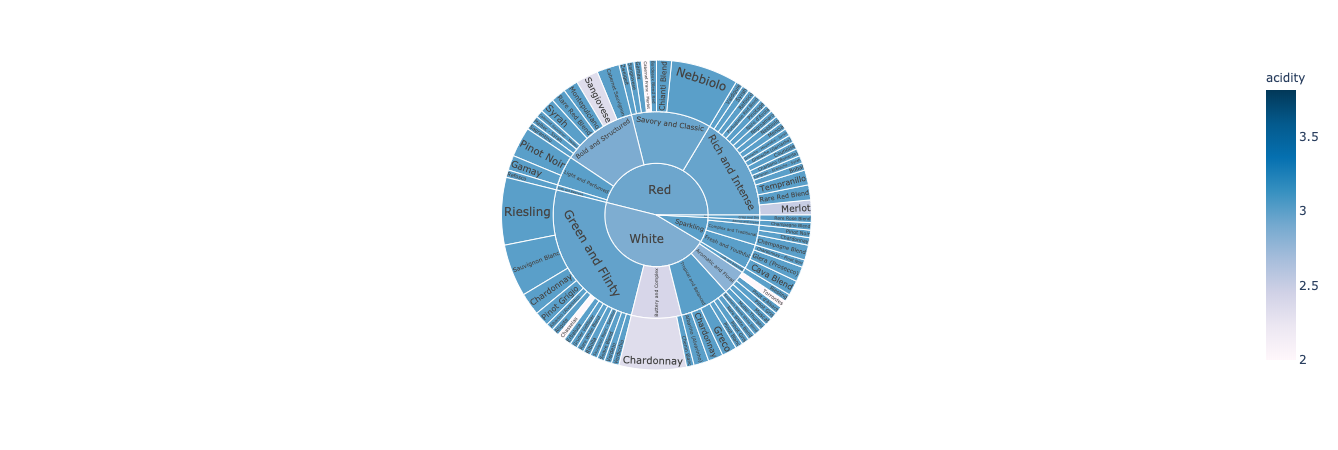

In [32]:
fig = px.sunburst(df,path=['type','Wine Style','Grape/Blend'],
                  color='acidity',color_continuous_scale='PuBu',
                  color_continuous_midpoint=np.average(df['acidity'])
                 )
fig.write_html('images/wineStyle_acidity.html')
fig.show()

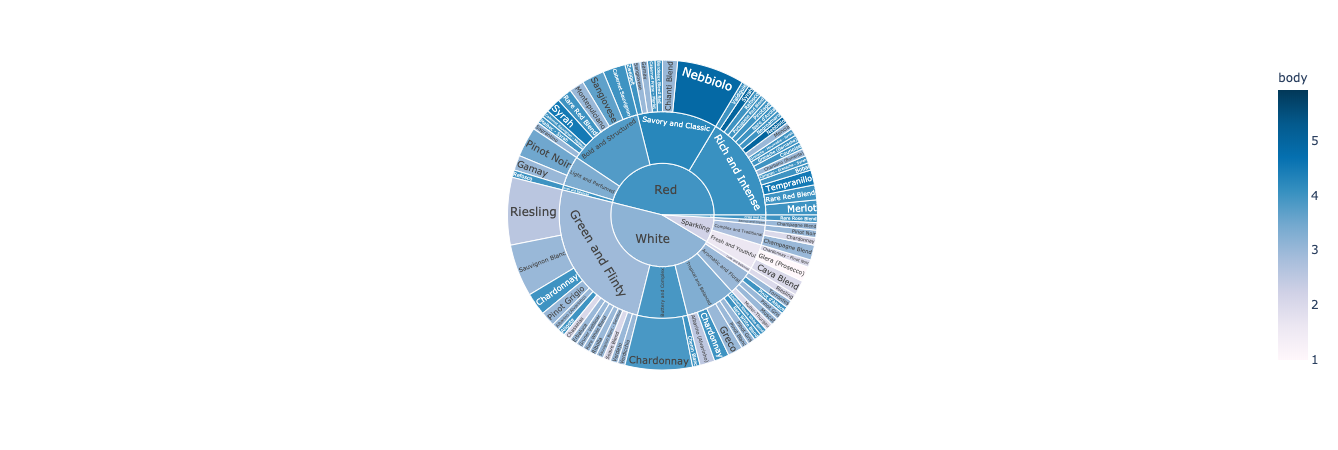

In [31]:
fig = px.sunburst(df,path=['type','Wine Style','Grape/Blend'],
                  color='body',color_continuous_scale='PuBu',
                  color_continuous_midpoint=np.average(df['body'])
                 )
fig.write_html('images/wineStyle_body.html')
fig.show()

### Flavor Wheel

In [17]:
tasting_notes=joblib.load('Wines/tasting_notes.pkl')

records = []
for t in tasting_notes:
    d = {}
    for k,v in t.items():
        d['id']=k
        d['notes']=list(
            {x['note'].split(' mentions of')[-1].replace(' notes','').strip() for x in v})
        d['tags']=list({x['tag'] for x in v})
    records.append(d)

In [18]:
nt_map = []
count = 0 
for t in tasting_notes:
    d = {}
    for k,value in t.items():
        if k not in df['id'].to_list():
            continue 
        for v in value:
            d = {'id':k}
            d['note'] = v['note'].split('mentions of')[-1].replace(' notes','').strip()
            d['tag']=v['tag']
            nt_map.append(d)

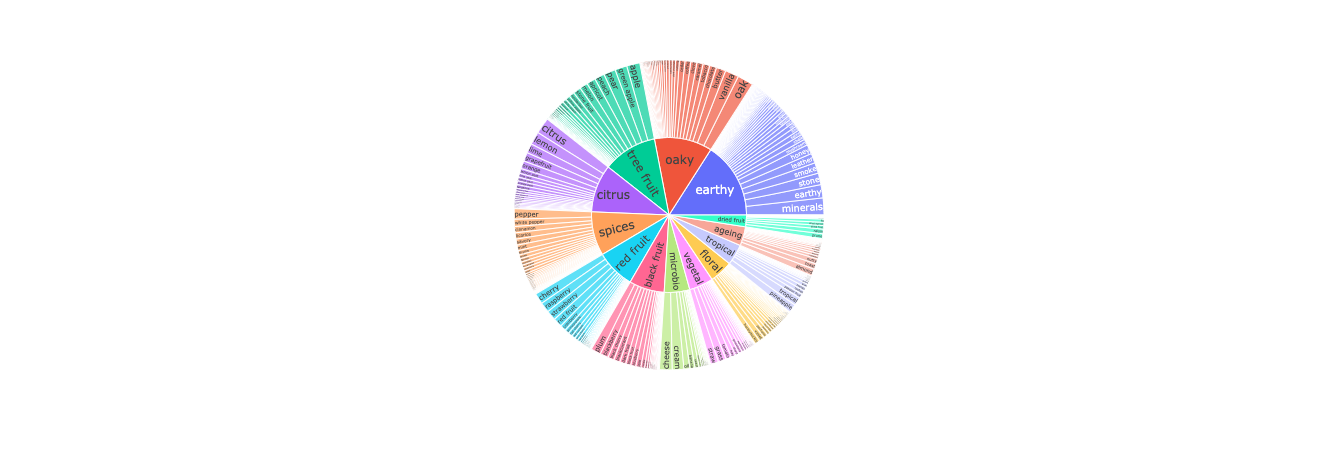

In [30]:
taste_df = pd.DataFrame.from_records(nt_map).drop_duplicates()
fig = px.sunburst(taste_df,path=['note','tag'])
fig.write_html('images/flavor_wheel.html')
fig.show()

### Co-occurrence of Tasting Notes

In [20]:
from chord import Chord
import itertools

In [21]:
# get top 3 tasting notes
records = []
for t in tasting_notes:
    d = {}
    for k,v in t.items():
        d['id']=k
        for i in range(0,3):
            for value in v:
                if value['index']==i:
                    note = value['note'].split(' mentions of ')[-1].replace('notes','').strip()
                    d[f"note_{i+1}"]=note
        
    records.append(d)

In [22]:
co_occ = pd.DataFrame.from_records(records)
co_occ = co_occ[['note_1','note_2']].dropna()
co_occ = list(itertools.chain.from_iterable((i, i[::-1]) for i in co_occ.values))

In [23]:
matrix = pd.pivot_table(
    pd.DataFrame(co_occ), index=0, columns=1, aggfunc="size", fill_value=0
).values.tolist()
names = np.unique(co_occ).tolist()

In [24]:
colors = ["#A6B91A", "#705746", "#6F35FC", "#F7D02C",
          "#D685AD", "#C22E28", "#EE8130", "#A98FF3",
          "#735797", "#7AC74C", "#E2BF65", "#96D9D6",
          "#A8A77A", "#A33EA1", "#F95587", "#B6A136",
          "#B7B7CE", "#6390F0"];

In [27]:
chord_diagram = Chord(matrix,names,colors=colors,wrap_labels=True)
chord_diagram.show()

In [29]:
chord_diagram.to_html('images/chord.html')